In [1]:
import albumentations as A
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [77]:
DATA_ROOT = '/opt/ml/data/carview_crosswalk'
IMG_LOCATE = os.path.join(DATA_ROOT, 'images/train')
GT_LOCATE = os.path.join(DATA_ROOT, 'gt/train')
img_list = [i.split('.')[0] for i in os.listdir(os.path.join(DATA_ROOT, 'images/train'))]
print(len(img_list))
i = 0

1614


16.47309027777778


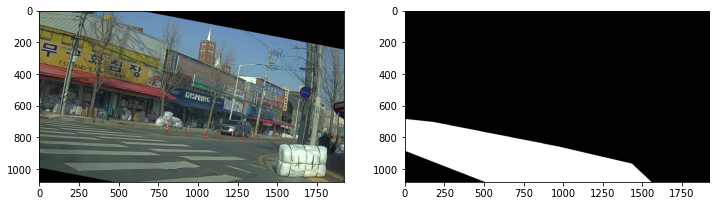

In [129]:
image = cv2.imread(os.path.join(IMG_LOCATE, img_list[i]+'.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

anno = cv2.imread(os.path.join(GT_LOCATE, img_list[i]+'.png'))

transform = A.Affine(p=1)(image=image, mask=anno)

fix, ax= plt.subplots(ncols=2, nrows=1, figsize=(12,9))
ax[0].imshow(transform['image'])
ax[1].imshow(np.where(transform['mask']==1, 255, transform['mask']))
#20percent 이상인 애들만
print(len(np.where(transform['mask']==1)[0])/(1920*1080*3)*100)
plt.show()

uint8
(1080, 1920, 3)


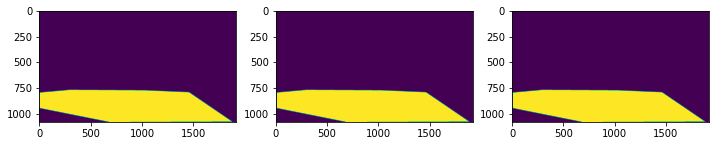

In [47]:
print(anno.dtype)
print(anno.shape)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,9))
ax[0].imshow(anno[:,:,:1])
ax[1].imshow(anno[:,:,1:2])
ax[2].imshow(anno[:,:,2:3])

plt.show()

In [92]:
contours, hierachy = cv2.findContours(image=anno[:,:,:1], mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

dummy = np.zeros_like(anno)
# cv2.drawContours(dummy, contours, -1, (255,0,0),10)

# print(sum(anno==dummy))

# plt.imshow(dummy)

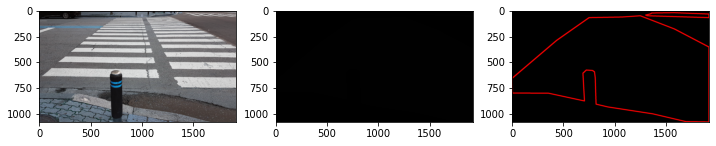

In [75]:
#MP_SEL_SUR_000033.jpg 2개
#MP_SEL_SUR_000110.jpg 5개
NIMG_ROOT = '/opt/ml/lab/datas'
file_name = 'MP_SEL_SUR_000033'
target_img = cv2.imread(os.path.join(NIMG_ROOT, f'images/{file_name}.jpg'))
target_gt = cv2.imread(os.path.join(NIMG_ROOT, f'gt/{file_name}.png'))

contours, hierachy = cv2.findContours(image=target_gt[:,:,:1], mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

dummy = np.zeros_like(target_gt)
cv2.drawContours(dummy, contours, -1, (255,0,0),10)

fig,ax = plt.subplots(ncols=3, nrows=1, figsize=(12,9))
ax[0].imshow(target_img)
ax[1].imshow(target_gt)
ax[2].imshow(dummy)
plt.show()

1
shape : (1080, 1920, 3)
box coord : 
[[   4  767]
 [1884  767]
 [   4 1080]
 [1884 1080]]
ratio of crosswalk in images : 0.2842023533950617
w = 400, h = 150
(150, 400, 3)


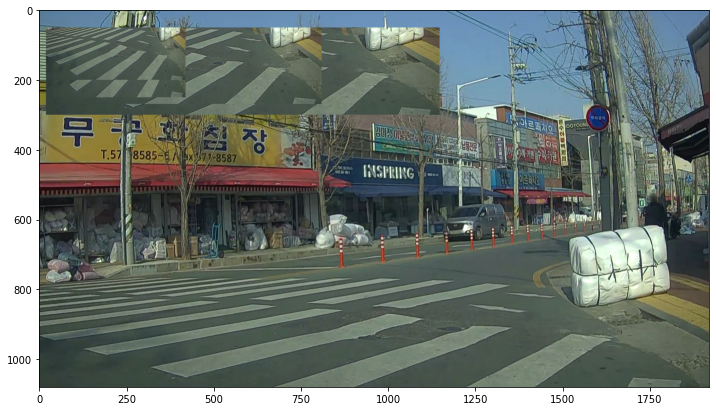

In [136]:
# 50% 이상은 탈락
# 20% - 30% : 1450 장
# contour 가 1개인 경우에만 paste 적용
# 1. contour 를 포함하는 최소 박스를 그린다
# 2. 그 박스를 잘라내서 일정 비율로 감소
# 3. 어딘가(.....?)에 붙이는 작업을 진행한드아
#  3.1 좌표를 활용하여 가로, 세로, 무게중심을 구한다.
#  3.2 가로가 긴 경우, 위 아래의 여유를 확인 
#  3.3 세로가 긴 경우, 좌 우의 여유를 확인
print(len(contours))

image, anno
x,y,w,h = cv2.boundingRect(contours[0])
# x,y,w,h
# dummy = cv2.drawContours(dummy,[box], 0, (0,255,0), 10)
box = np.array([[x,y], [x+w,y], [x,y+h], [x+w ,y+h]])
dummy = cv2.fillPoly(dummy , [box], 255)
d_shape = dummy.shape
#fillpoly 로 한 차원에만 255로 값을 채워주기 때문에 dim 까지 곱할 핑료가 없다.
print(f'shape : {d_shape}\nbox coord : \n{box}')
print(f'ratio of crosswalk in images : {len(np.where(dummy==255)[0])/(d_shape[0] * d_shape[1])}')
# print(f'width: {} , height: {}')

ratio = w / h

WIDTH = dummy.shape[1]
HEIGHT = dummy.shape[0]

# Contour 영역을 축소해서 붙여넣는다.
img_patch = image[y:y+h, x:x+w]
ann_patch = anno[y:y+h, x:x+w]

# img_patch = cv2.resize(img_patch, (0,0), fx=0.5, fy=0.5) 

x_start = 20
y_start = 50

# 가로가 더 긴 경우
if ratio > 1:
    #w = int(round(w*0.6*0.7, 0))
    #h = int(round(h*0.7, 0))
    w = 400
    h = 150

    print(f"w = {w}, h = {h}")
    img_patch = cv2.resize(img_patch, dsize=(w, h))
    print(img_patch.shape)

    if (y+h+y) / 2 > HEIGHT / 2:
        # 활용 가능한 Box 영역 : (0,0) ~ (WIDTH,y)
        # 위쪽 영역 남음
        
        image[y_start:y_start+h, x_start:x_start+w] = img_patch

        pass
    else:
        # 활용 가능한 Box 영역 : (0,y+h) ~ (WIDTH, HEIGHT)
        # 아래쪽 영역 남음
        image[y_start+y+h:y_start+y+h+h, x_start:x_start+w] = img_patch
        pass

# 세로가 더 긴 경우
else:
    #w = int(round(w*0.7, 0))
    #h = int(round(h*0.6*0.7, 0))
    w = 150
    h = 400

    print(f"w = {w}, h = {h}")
    img_patch = cv2.resize(img_patch, dsize=(w, h))
    print(img_patch.shape)

    if (x+w+x) > WIDTH:
        # 활용 가능한 Box 영역 : (0,0) ~ (x,HEIGHT)
        # 왼쪽 영역이 남음
        image[y_start:y_start+h, x_start:x_start+w] = img_patch
        pass
    else:
        # 활용 가능한 Box 영역 : (x+w,0) ~ (WIDTH, HEIGHT)
        # 오른쪽 영역이 남음
        image[y_start:y_start+h, x_start+x+w:x_start+x+w+w] = img_patch
        pass



#rect_center_point = [w/2, h/2]
#img_center_point = [d_shape[1]/2, d_shape[0]/2]
#print(rect_center_point, img_center_point)
plt.figure(figsize=(12,9))
plt.imshow(image)
# cv2.rectangle()